## Data Visualisation

## Objectives

- Prepare the dataset for data analysis by resizing the images and putting them in an array
- The image shape will be saved for later use
- Create images of average and difference between label sets. Create an image montage

## Inputs

- inputs/cherry_leaves_raw_dataset/cherry-leaves/train
- inputs/cherry_leaves_raw_dataset/cherry-leaves/validation
- inputs/cherry_leaves_raw_dataset/cherry-leaves/test

## Outputs

- image_shape.pkl

## Install dependencies

In [2]:
pip install -r /workspace/mildew-detection/requirements.txt

You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.



## Change working directory

Change working directory from current to parent folder.

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

In [4]:
os.chdir("/workspace/mildew-detection")
print("You set a new current directory.")

You set a new current directory.


In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

## Set input directories

In [6]:
data_dir = "inputs/cherry_leaves_raw_dataset/cherry-leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

## Set output directories

In [7]:
version = "v1"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory already exists, please create a new version.")
else:
    os.makedirs(name=file_path)

This directory already exists, please create a new version.


## Set label names

In [8]:
labels = os.listdir(train_dir)
print("The image labels are ", labels)

The image labels are  ['healthy', 'powdery_mildew']


## Import libraries

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Image shape

Resize images and plot image height and width

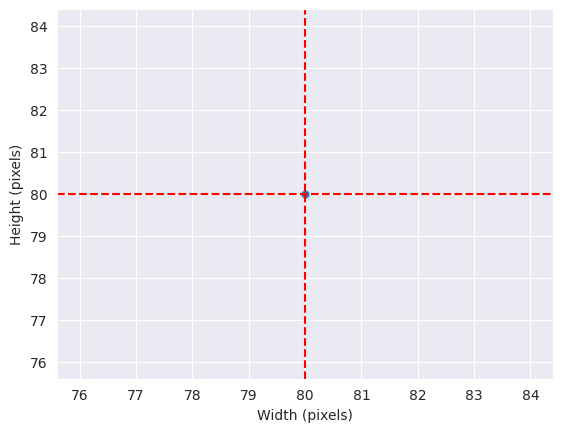

Width average: 80 
Height average: 80


In [10]:
from PIL import Image

# Target dimensions 
target_dim = (80, 80)

dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_dir + '/'+ label):
    img = Image.open(train_dir + '/' + label + '/' + image_filename)
    img_resized = img.resize(target_dim, Image.LANCZOS)
    d1, d2 = img_resized.size
    dim1.append(d1)  # image height
    dim2.append(d2)  # image width

sns.set_style("darkgrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.1)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

In [11]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(80, 80, 3)

## Save image shape

In [12]:
image_shape = dim2_mean, dim1_mean, 3
if "image_shape.pkl" not in file_path:
    joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

## Data visualisation

Load image shapes and labels in an array

In [13]:
# Function to convert images into a numpy array

from tensorflow.keras.preprocessing import image

def load_img_array(data_dir, resized=(80,80), n_img_per_label=30):
    X, y = np.array([], dtype="int"), np.array([], dtype="object")
    labels = os.listdir(data_dir)

    for label in labels:
        count = 0
        for img_file in os.listdir(data_dir + "/" + label):
            if count < n_img_per_label:
                file = image.load_img(data_dir + "/" + label + "/" + img_file, color_mode="rgb", target_size = resized)
                if image.img_to_array(file).max() > 1:
                    resize_img = image.img_to_array(file) /255
                else:
                    resize_img = image.img_to_array(file)
                X = np.append(X, resize_img).reshape(-1, resized[0], resized[1], resize_img.shape[2])
                y = np.append(y, label)
                count += 1
    
    return X, y

In [14]:
X, y = load_img_array(data_dir=train_dir, 
                resized=image_shape, 
                n_img_per_label=30)
print(X.shape, y.shape)

(60, 80, 80, 3) (60,)


## Display average image by label type, diference image

In [15]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

def avg_diff_image_for_label(X, y, label, figsize=(10, 5), save_image=False, file_path="./"):
    """
    Save average and difference images for each specific label
    - 'average' image is the total of all images with that label, divided by the number of images
    - The 'difference' image is comparing this average image with the average of all images, regardless of label

    X = numpy array containing image data
    y = numpy array containing corresponding labels for the image

    """
    sns.set_style("white")

    if label not in np.unique(y):
        print(f"Label {label} does not exist. Available labels are: {np.unique(y)}")
        return

    # Calculate mean image for specified label
    images_label = subset_image_label(X, y, label)
    label_avg = np.mean(images_label, axis=0)

    # Plot the difference between label_avg and overall average
    diff_mean = label_avg - np.mean(X, axis=0)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].imshow(label_avg, cmap='gray')
    axes[0].set_title(f'Average image: {label}')
    axes[1].imshow(diff_mean, cmap='gray')
    axes[1].set_title(f'Difference image: Avg {label} vs. Overall Avg')

    if save_image == True:
        plt.savefig(f"{file_path}/outputs/v1/avg_diff_{label}.png", bbox_inches='tight', dpi=150)
    
    plt.tight_layout()
    plt.show()
    

Display and save the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


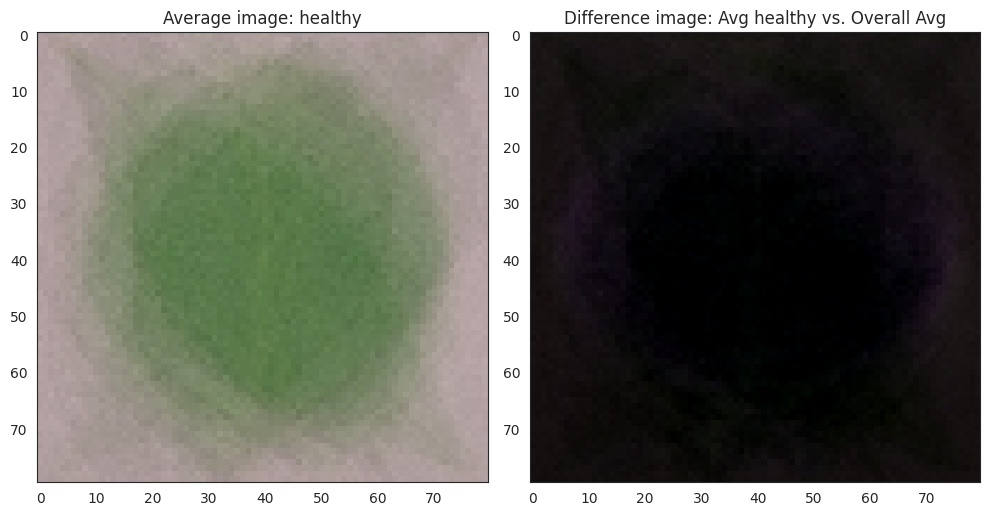

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


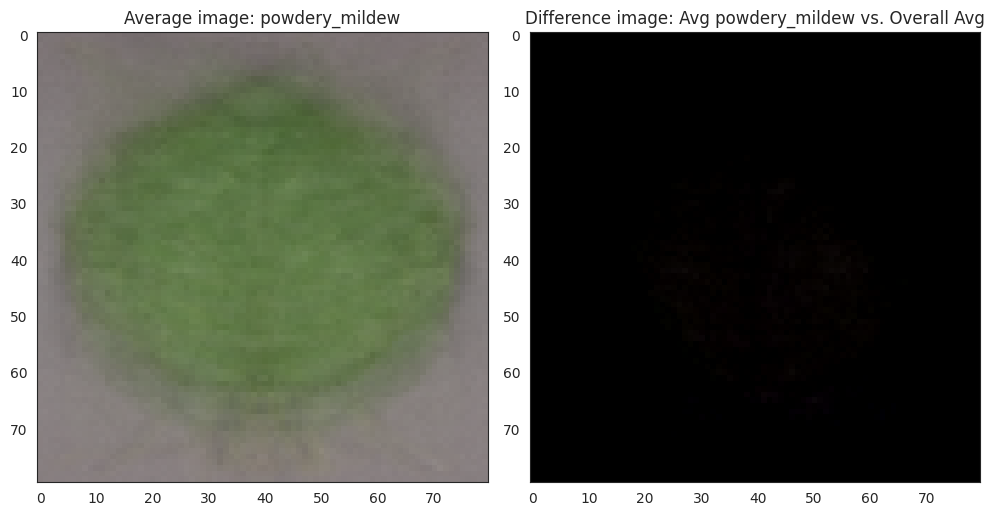

In [16]:
avg_diff_image_for_label(X, y, label='healthy', save_image=True)
avg_diff_image_for_label(X, y, label='powdery_mildew', save_image=True)

## Image montage

Create a function to display a montage of images from each label

In [17]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The options are: {labels}")

Run the image montage for both labels

healthy


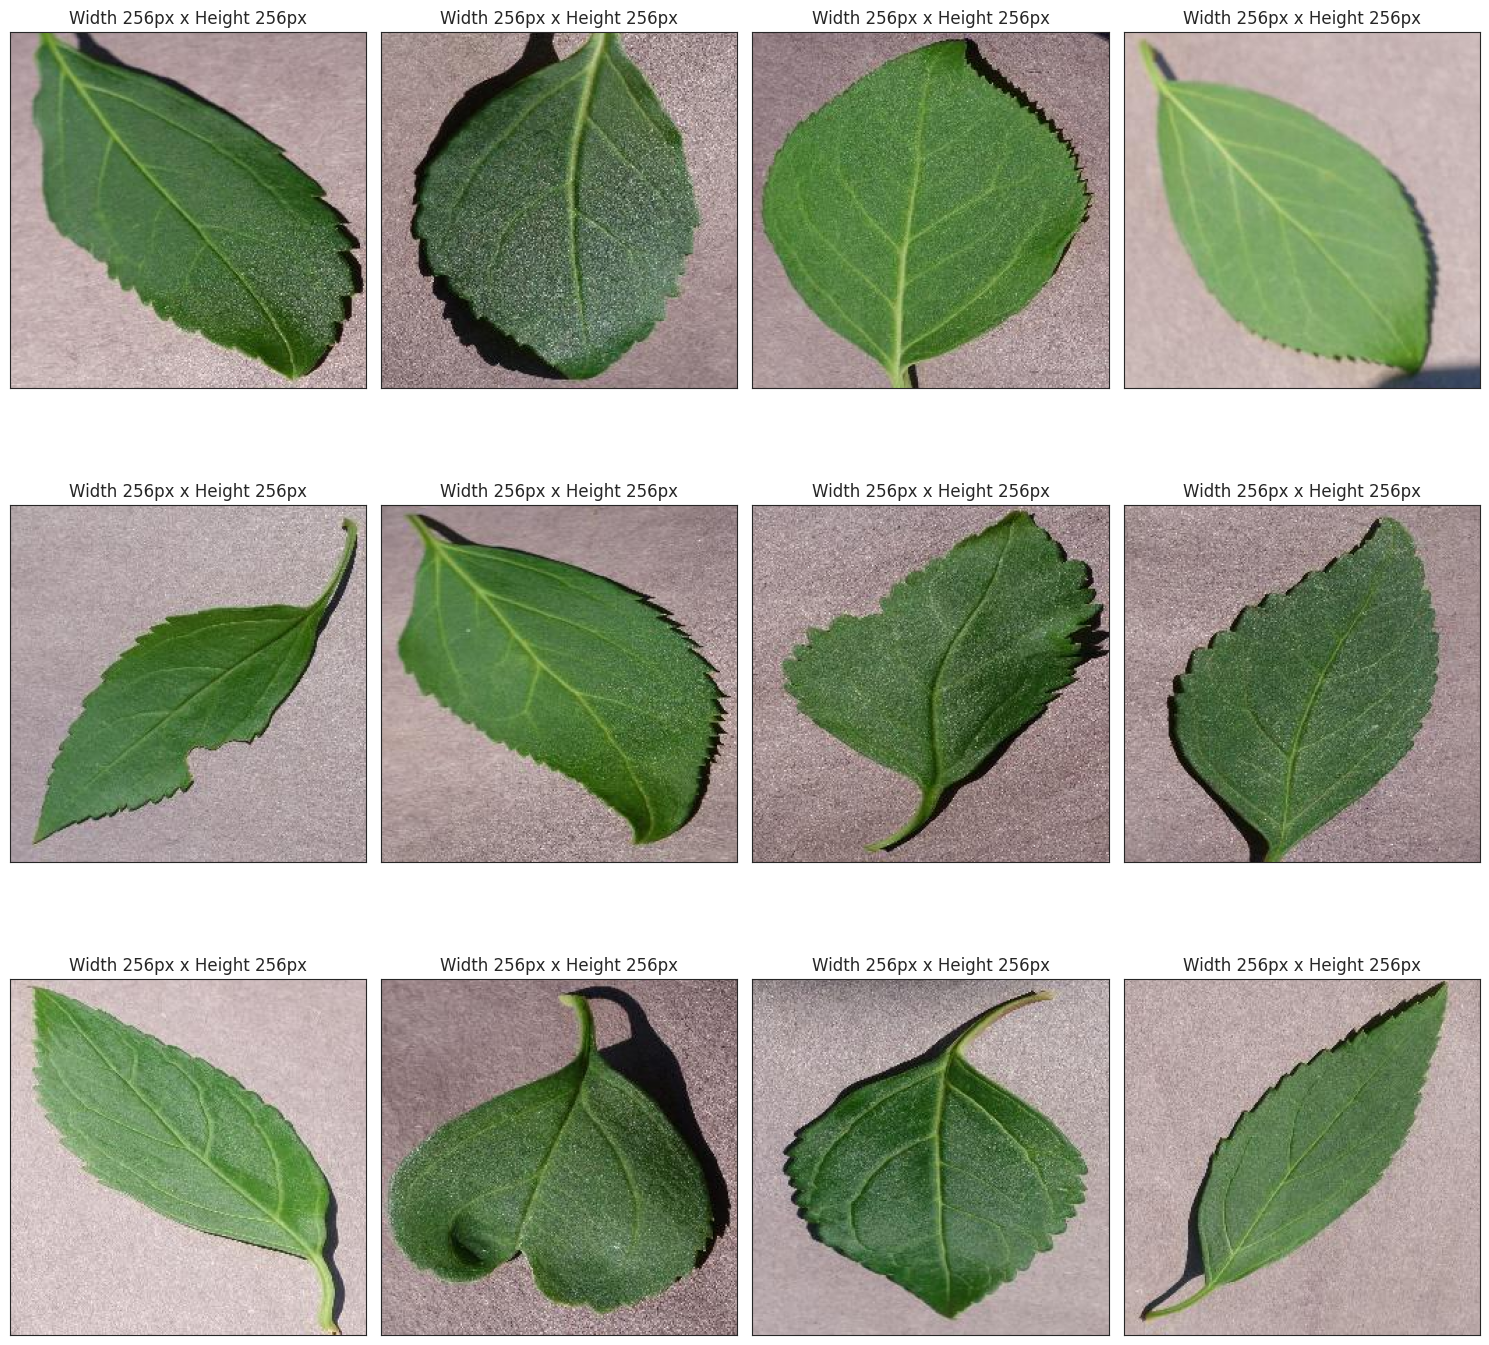

powdery_mildew


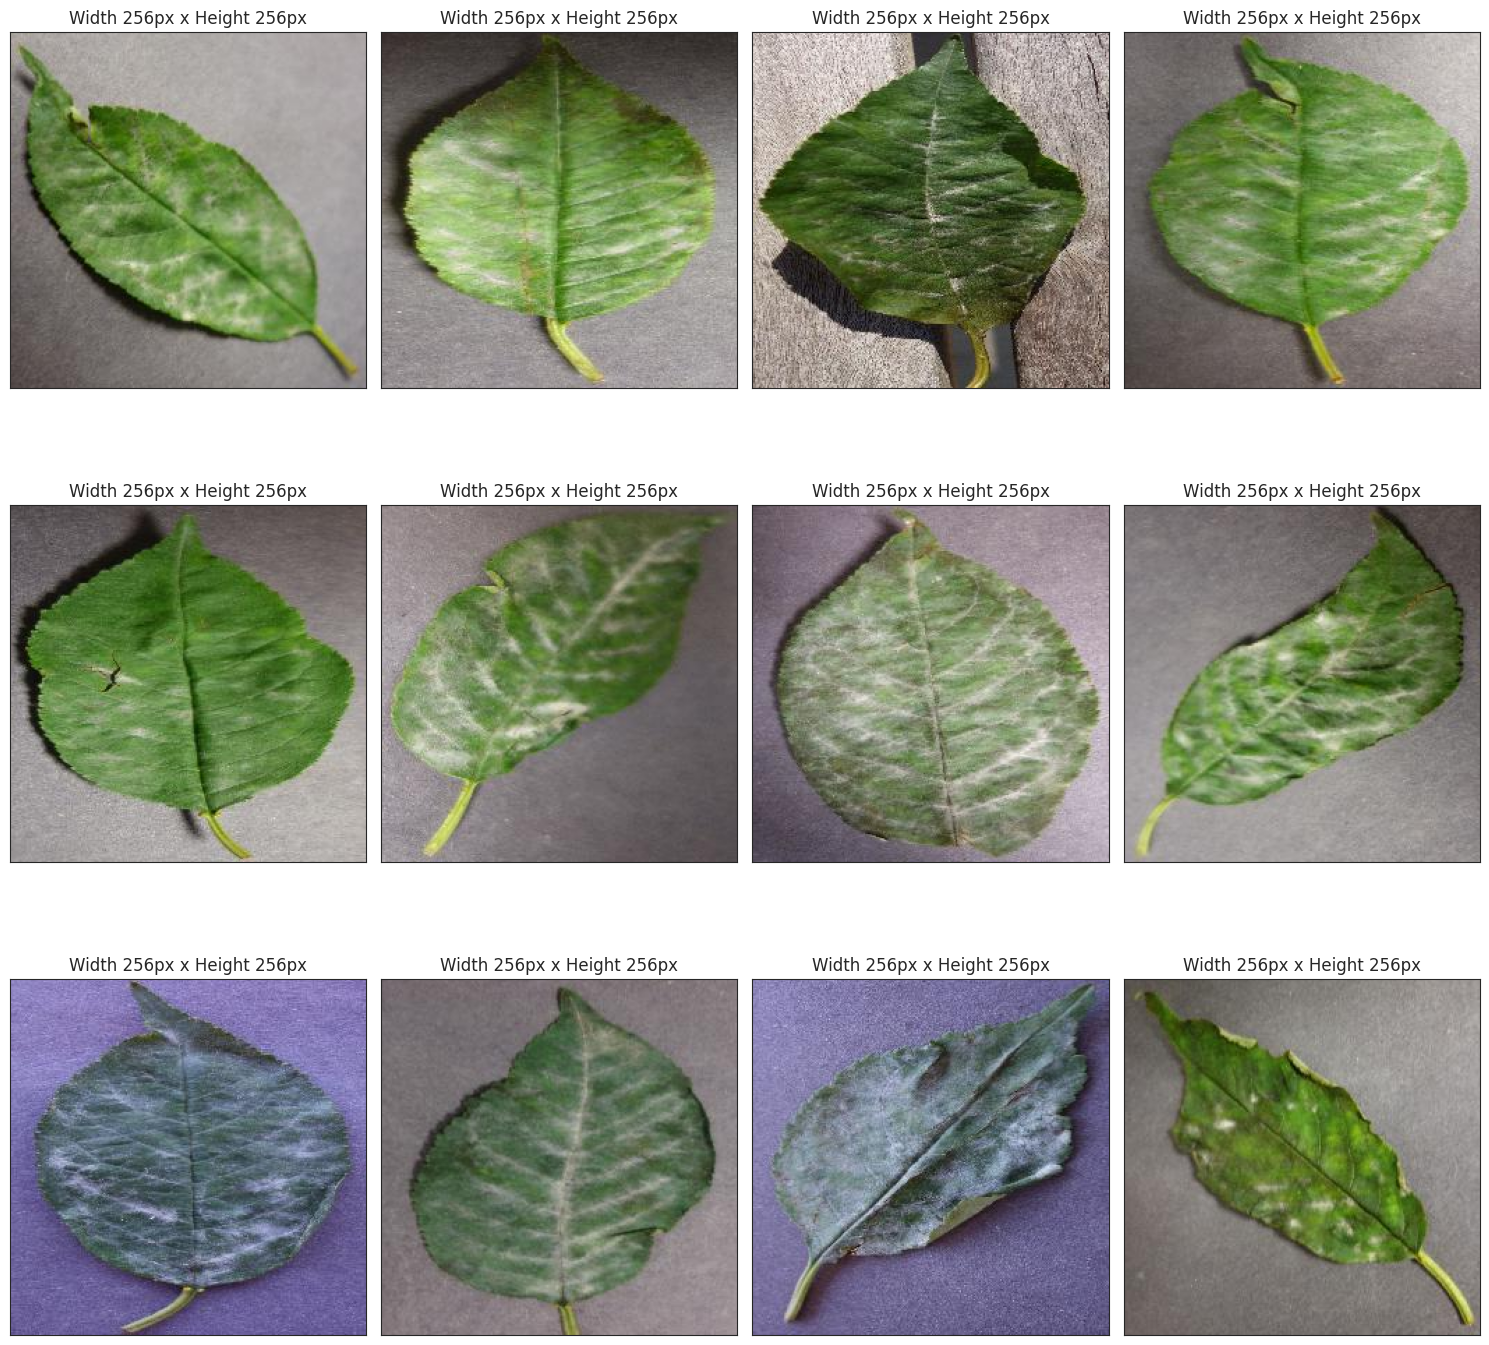

In [18]:
for label in labels:
    print(label)
    image_montage(dir_path=train_dir,
                  label_to_display=label,
                  nrows=3, ncols=4,
                  figsize=(15, 15)
                  )
    

## Conclusions

- The images have been resized successfully and are ready for the modelling process
- The image shape has been saved
- A montage, average images for each label and difference images have been created

## Next steps

- An ML model will be created to learn to visually differentiate between healthy/infected leaves with the highest accuracy possible. This can then be used in a dashboard for the client